# Data Preprocessing

In [1]:
import pandas as pd
import stumpy
import numpy as np

import os
import random
import time # just for dev purpose
from IPython.display import display # Just for displaying DF nicely

from itertools import product

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

from util.util import *

### Reading only one file

In [2]:
# Validation Logs
csvPath = "logs/smartRPA/"

filename = "2020-11-07_17-28-29__250_25_40_3.csv"
#filename = "2020-11-07_17-41-57__1000_100_80_4.csv"
#filename = "2020-11-07_21-09-26__750_100_80_5.csv"
#filename = "2020-11-17_15-05-40__500_100_40_4.csv"

filenamesList = ["2020-11-17_15-05-40__500_100_40_4.csv","2020-11-07_21-09-26__750_100_80_5.csv",
                 "2020-11-07_17-41-57__1000_100_80_4.csv","2020-11-07_17-28-29__250_25_40_3.csv"]

df = pd.read_csv(csvPath + filename, encoding = "latin-1")

In [8]:
# Sparkasse 1h test log
csvPath = "logs/Banking/"

filename = "TSMD Log Sparkass_combined.csv"
df = pd.read_csv(csvPath + filename, encoding = "latin-1")

In [3]:
df

,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,tag_title,tag_value,tag_checked,tag_html,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full
0,0,415130900000000,SmartRPA by marco2012,complete,2020-04-15T13:09:35.000,melissa36,Browser,Chrome,removeBookmark,NaN,...,NaN,civil,NaN,NaN,NaN,NaN,NaN,NaN,"id(""cup/section[1]"")","id(""cup/section[1]"")"
1,1,415130900000000,SmartRPA by marco2012,complete,2020-04-15T13:10:02.000,melissa36,Browser,Microsoft Excel,closeWindow,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,415130900000000,SmartRPA by marco2012,complete,2020-04-15T13:10:57.000,melissa36,Browser,Chrome,disableBrowserExtension,NaN,...,NaN,store,NaN,NaN,NaN,NaN,NaN,NaN,"id(""cup/section[1]"")","id(""cup/section[1]"")"
3,3,415130900000000,SmartRPA by marco2012,complete,2020-04-15T13:11:25.000,melissa36,Browser,Chrome,clickRadioButton,NaN,...,NaN,table,NaN,NaN,NaN,NaN,NaN,NaN,"id(""cultural"")","id(""cultural"")"
4,4,415130900000000,SmartRPA by marco2012,complete,2020-04-15T13:11:51.000,melissa36,Browser,Chrome,typed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"id(""political/div[1]/url[0]"")","id(""political/div[1]/url[0]"")"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,6245,627012708000000,SmartRPA by marco2012,complete,2020-06-27T01:37:00.000,whitneydavis,OperatingSystem,Explorer,openFolder,/soldier/because.doc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6246,6246,627012708000000,SmartRPA by marco2012,complete,2020-06-27T01:37:30.000,whitneydavis,OperatingSystem,Explorer,deleted,/anything/clearly.key,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6247,6247,627012708000000,SmartRPA by marco2012,complete,2020-06-27T01:37:42.000,whitneydavis,OperatingSystem,Explorer,moved,/sea/eat.mp4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6248,6248,627012708000000,SmartRPA by marco2012,complete,2020-06-27T01:38:07.000,whitneydavis,OperatingSystem,Explorer,Unmount,/two/any.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating a mix DF from multiple files

This process creates a DF using cases from different files that are within the filenameList.

For each file
- Select 5 unique case ids
- Get all events per case
- Append these events to the mixed_df

Result: (5 * Number of Files) Cases in a new DF

In [4]:
# Create a df containing cases from different Agostinelli logs to vary patterns
mixed_df = pd.DataFrame() 
for file in filenamesList:
    df = pd.read_csv(csvPath + file)
    # Get the first 5 unique case:concept:name values
    unique_cases = df['case:concept:name'].unique()[:5]
    
    # Filter the DataFrame to keep only rows with those unique values
    df_filtered = df[df['case:concept:name'].isin(unique_cases)]
    concat_dfs = [mixed_df,df_filtered]
    mixed_df = pd.concat(concat_dfs,ignore_index=True)

df = mixed_df
#df

### Creating a validation data set from available logs

Objective: Create a dataframe that mimics a long time recording of users, which contains routines

Method:
  1. Get user interactions (a) and create a set of user actions (A)
  2. Select random actions (1-n consequtive per looping) append them into a dataframe (D) until a upper limit (x) is reached
        - The upper limit x is considered as 1 action per 3 seconds in a 8 hour work day => 8* 60 * (60/3) = 9600 actions a day
  4. Get routines (r) (1-m overall) and insert the routines (r) o-times at random points into the dataframe (D)
        - The routines need not interrupt themselfs, otherwise no motif could be discovered (for future tests, the could interrupt as well)

Result: A dataframe (D) with x + (o * len(r)) number of actions containing m routines at random points

In [ ]:
start_time = time.time()
# ---- 1 Get user interactions ----
df = read_csvs_and_combine(csvPath)
# Drop duplicates based on equality assumption in https://doi.org/10.1016/j.compind.2022.103721                                                                                     
subset=["category","application","concept:name","event_src_path","event_dest_path","browser_url","xpath"]
df = df.drop_duplicates(subset=subset)
print(f"There are {len(df)} unique events in the dataframe")

time2 = time.time()
print(f"Row creation took {time2-start_time} \n")

# ---- 2 Create shuffled UI log ----
uiLog = get_rand_uiLog(df)

time3 = time.time()
print(f"UiLog creation took {time3-time2} \n")

# ---- 3 Add routines in the dataframe ----
column_name = 'case:concept:name'
m = 1
o = 3
random_list = get_random_values(df, column_name, m, 15)

routine = df[df[column_name] == random_list[0]]
modified_df, indices = insert_rows_at_random(uiLog, routine, o, shuffled=False, reduced=False, reduced_by=20)

# ---- 4 Outputting stuff ----
end_time = time.time()
print(f"Random case insertion took {end_time-time3} \n")
print(random_list)
print(indices)

Maximum row limit of 100000 reached. Stopping reading additional files.
There are 17593 unique events in the dataframe
Row creation took 18.146983861923218 

UiLog creation took 0.016021728515625 

Random case insertion took 0.09455490112304688 

[1014202614000000]
[3937, 4717, 5285]


In [ ]:
df = modified_df
df[df["case:concept:name"]==random_list[0]]

,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,tag_title,tag_value,tag_checked,tag_html,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full
1537,110,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:33:24.000,tconrad,Browser,Chrome,modifyBookmark,NaN,...,NaN,set,NaN,NaN,NaN,NaN,NaN,NaN,"id(""sing/div[3]/div[1]"")","id(""sing/div[3]/div[1]"")"
1667,116,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:37:26.000,tconrad,Browser,Chrome,unmutedTab,NaN,...,NaN,air,NaN,NaN,NaN,NaN,NaN,NaN,"id(""become/li[2]"")","id(""become/li[2]"")"
3937,100,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:26:59.000,tconrad,Browser,Chrome,changeField,NaN,...,NaN,crime,NaN,NaN,NaN,NaN,NaN,NaN,"id(""sing/div[3]/div[1]"")","id(""sing/div[3]/div[1]"")"
3938,101,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:27:59.000,tconrad,Browser,Chrome,startDownload,NaN,...,NaN,live,NaN,NaN,NaN,NaN,NaN,NaN,"id(""become/li[2]"")","id(""become/li[2]"")"
3939,103,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:28:54.000,tconrad,Browser,Chrome,clickedNotification,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"id(""become/li[2]"")","id(""become/li[2]"")"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,104,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:29:38.000,tconrad,Browser,Microsoft Word,doubleClick,/special/third.mov,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6788,113,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:35:33.000,tconrad,Browser,Chrome,detachTab,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"id(""sing/div[3]/div[1]"")","id(""sing/div[3]/div[1]"")"
7184,111,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:34:11.000,tconrad,Browser,Chrome,startDownload,NaN,...,NaN,subject,NaN,NaN,NaN,NaN,NaN,NaN,"id("""")","id("""")"
8953,107,1014202614000000,SmartRPA by marco2012,complete,2020-10-14T20:31:21.000,tconrad,Browser,Chrome,detachTab,NaN,...,NaN,draw,NaN,NaN,NaN,NaN,NaN,NaN,"id(""become/li[2]"")","id(""become/li[2]"")"


### Getting the tuple data ready
#### Agostinelli Log

In [5]:
conceptNames = {
    'beforeSaveWorkbook','urlHashChange','contextMenu','clickCheckboxButton','clickRadioButton','navigateTo','link','typed','form','reload','clickTextField',
    'clickButton','clickLink','selectOptions','selectText','submit','changeField','doubleClick','dragElement','cancelDialog','fullscreen','attachTab',
    'detachTab','newBookmark','removeBookmark','modifyBookmark','moveBookmark','startDownload','erasedDownload','installBrowserExtension','uninstallBrowserExtension',
    'enableBrowserExtension','disableBrowserExtension','closedNotification','clickedNotification','newWindow','closeWindow','newTab','closeTab','moveTab',
    'mutedTab','unmutedTab','pinnedTab','unpinnedTab','audibleTab','zoomTab','changeHistory','created','modified','deleted','Mount','Unmount','moved',
    'programOpen','programClose','selectFile','selectFolder','hotkey','insertUSB','printSubmitted','openFile','openFolder','copy','paste','cut','openWindow','closeWindow',
    'resizeWindow','newWorkbook','openWorkbook','addWorksheet','saveWorkbook','printWorkbook','closeWorkbook','activateWorkbook','deactivateWorkbook','modelChangeWorkbook',
    'newChartWorkbook','afterCalculate','selectWorksheet','deleteWorksheet','doubleClickCellWithValue','doubleClickEmptyCell','rightClickCellWithValue',
    'rightClickEmptyCell','sheetCalculate','editCellSheet','deselectWorksheet','followHiperlinkSheet','pivotTableValueChangeSheet','getRange',
    'getCell','worksheetTableUpdated','addinInstalledWorkbook','addinUninstalledWorkbook','XMLImportWorkbook','XMLExportWorkbook','activateWindow',
    'deactivateWindow','doubleClickWindow','rightClickWindow','newDocument','openDocument','changeDocument','saveDocument','printDocument','activateWindow',
    'deactivateWindow','rightClickPresentation','doubleClickPresentation','newPresentation','newPresentationSlide','closePresentation','savePresentation',
    'openPresentation','printPresentation','slideshowBegin','nextSlideshow','clickNextSlideshow','previousSlideshow','slideshowEnd','SlideSelectionChanged',
    'startupOutlook','quitOutlook','receiveMail','sendMail','logonComplete','newReminder'
    }

# Update dict creation to sort the data before to create meaningful dicts -> Equal applications are grouped together for example
conceptNamesDict = createDict(conceptNames)
conceptNamesDict = createDict(set(df.sort_values(by=['concept:name'])['concept:name'].unique()))
applicationDict = createDict(set(df.sort_values(by=['application'])['application'].unique()))
categoriesDict = createDict(set(df.sort_values(by=['category'])['category'].unique()))

print(f"The number of concept names is {len(conceptNamesDict)}, of applications is {len(applicationDict)}, and categories is {len(categoriesDict)}")

# Add new columns with IDs (corrected call to apply)
# Agostinelli Data
df['concept:name:id'] = df.apply(lambda row: get_key(row, conceptNamesDict, 'concept:name'), axis=1)
df['application:id'] = df.apply(lambda row: get_key(row, applicationDict, 'application'), axis=1)
df['category:id'] = df.apply(lambda row: get_key(row, categoriesDict, 'category'), axis=1)

# Print the updated DataFrame
# For Agostinelli Data
print(df[["time:timestamp",'concept:name', 'application', 'category', 'concept:name:id', 'application:id', 'category:id']])

The number of concept names is 105, of applications is 11, and categories is 3
               time:timestamp    concept:name application         category  \
0     2020-10-22T08:42:44.000         Unmount    Explorer  OperatingSystem   
1     2020-10-22T08:43:41.000        openFile    Explorer  OperatingSystem   
2     2020-10-22T08:44:04.000         Unmount    Explorer  OperatingSystem   
3     2020-10-22T08:44:16.000             cut   Clipboard  OperatingSystem   
4     2020-10-22T08:44:53.000  printSubmitted    Explorer  OperatingSystem   
...                       ...             ...         ...              ...   
1620  2020-07-19T02:36:50.000      openFolder    Explorer  OperatingSystem   
1621  2020-07-19T02:36:55.000      openFolder    Explorer  OperatingSystem   
1622  2020-07-19T02:37:50.000      openFolder    Explorer  OperatingSystem   
1623  2020-07-19T02:38:29.000         deleted    Explorer  OperatingSystem   
1624  2020-07-19T02:38:41.000      openFolder    Explorer  Oper

## Data Preprocessing and Modeling

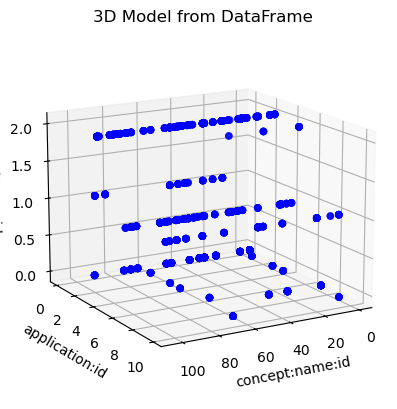

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract data from each column
x = df['concept:name:id']
y = df['application:id']
z = df['category:id']

# Plot the points
ax.scatter(x, y, z, c='blue', alpha=0.7)

# Set labels and title
ax.set_xlabel('concept:name:id')
ax.set_ylabel('application:id')
ax.set_zlabel('category:id')
ax.set_title('3D Model from DataFrame')

# Adjust view angles (optional)
ax.view_init(elev=15, azim=60)

# Show the plot
plt.show()

Make the multi dimensional Agostinelli log one dimensional using another tuple generator

Using the ideas ('concept:name:id','application:id', 'category:id') generated earlier in the process based on the dictonaries 

In [7]:
numbersDF = df[['concept:name:id', 'application:id', 'category:id']]

# Generate unique tuples for indexing the individual combinations of the rows mentioned
unique_df = numbersDF.drop_duplicates(subset=numbersDF.columns, keep='first')
tuples = [tuple(row[['concept:name:id', 'application:id', 'category:id']]) for i, row in unique_df.iterrows()]
       

df['id'] = df.apply(lambda row: get_id(row, tuples, columns=['concept:name:id','application:id', 'category:id']), axis=1)
# Print the updated DataFrame
print(df['id'])

0         0
1         1
2         0
3         2
4         3
       ... 
1620    102
1621    102
1622    102
1623     87
1624    102
Name: id, Length: 1625, dtype: int64


## Motife Discovery

From Time https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-a-Motif-Using-STUMP:

Time series motifs are approximately repeated subsequences found within a longer time series. Being able to say that a subsequence is “approximately repeated” requires that you be able to compare subsequences to each other. In the case of STUMPY, all subsequences within a time series can be compared by computing the pairwise z-normalized Euclidean distances and then storing only the index to its nearest neighbor. This nearest neighbor distance vector is referred to as the matrix profile and the index to each nearest neighbor within the time series is referred to as the matrix profile index. Luckily, the stump function takes in any time series (with floating point values) and computes the matrix profile along with the matrix profile indices and, in turn, one can immediately find time series motifs.

### Window Size Calculation

I propose a window size calculation based on break time. 
The break time method (windowSizeByBreak) calculates the percentil break time and then the avg. number of events between these breaks occuring.

E.g. the avg. break time is 300 seconds and the following breaks between event time stamps exist:
[100,210,333,100,11,300,222] 

Then there are on avg. 3 events between these breaks: Thus, the window size is set to 3.

In [8]:
# If the percentil is increased the number of elements should increate, but it does not, it decreases
# Something is wrong with this functionallity
# Occarm´s Razor: The most simple solution might be the best: Just take a guess instead of "Rätselraten"
percentil = 50
breakTime = 300 # 300 = 5 Min, 600 = 10 min, 900 = 15 min
third_quartile, quartile_indices, average_elements = windowSizeByBreak(df, "time:timestamp", breakTime, percentil)
if average_elements is not None:
    print(f"Average number of elements between {percentil} percentil breaks occurrences: {average_elements:.2f}")
else:
    print("Not enough data to calculate average")

print(f"The {percentil} percentil time difference between clicks is {third_quartile}s")


# Checking the avg. case length:
# Count occurrences of each concept name
concept_counts = df['case:concept:name'].value_counts()
average_entries = concept_counts.mean()
print(average_entries)

Average number of elements between 50 percentil breaks occurrences: 58.04
The 50 percentil time difference between clicks is 30.0s
81.25


### Run for smartRPA based File

In [9]:
starting_row = 0
ending_row = len(df)-1
#Extract ids and rows
ids = df.loc[starting_row:ending_row,'id'].tolist()
rows = [i for i in range(len(df.loc[starting_row:ending_row,'id']))]

# Manually set window size
window_size = 15

event_series = df.loc[starting_row:ending_row,'id'].values.astype(float)
tm_matrix = stumpy.stump(event_series, window_size)

motif_idx_tm = np.argsort(tm_matrix[:, 0])[0]
nearest_neighbor_idx_tm = tm_matrix[motif_idx_tm, 1]

print(f"The window size is {window_size}")
print(f"The motif is located at index {motif_idx_tm}")
print(f"The nearest neighbor is located at index {nearest_neighbor_idx_tm}\n")


The window size is 15
The motif is located at index 1140
The nearest neighbor is located at index 1340



### Run for artificial file

In [ ]:
starting_row = 0
ending_row = len(df)-1
#Extract ids and rows
ids = df.loc[starting_row:ending_row,'id'].tolist()
rows = [i for i in range(len(df.loc[starting_row:ending_row,'id']))]

print(f"The motif should be at {indices}")
for size in [5,10,15,20]:
    window_size = size
    
    event_series = df.loc[starting_row:ending_row,'id'].values.astype(float)
    tm_matrix = stumpy.stump(event_series, window_size)
    
    motif_idx_tm = np.argsort(tm_matrix[:, 0])[0]
    nearest_neighbor_idx_tm = tm_matrix[motif_idx_tm, 1]

    print(f"The window size is {window_size}")
    print(f"The motif is located at index {motif_idx_tm} and it is an artificial motif: {any(abs(motif_idx_tm - element) <= size for element in indices)}")
    print(f"The nearest neighbor is located at index {nearest_neighbor_idx_tm}\n")

NameError: name 'indices' is not defined

## Plotting

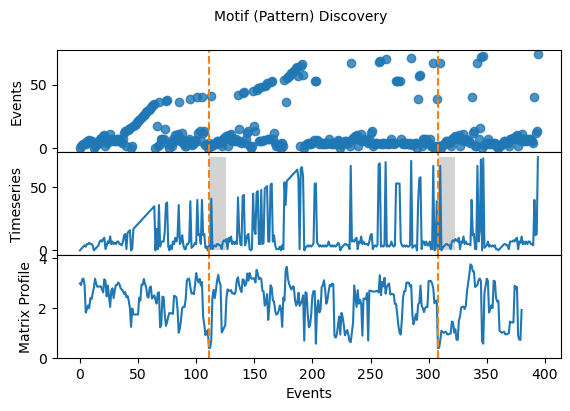

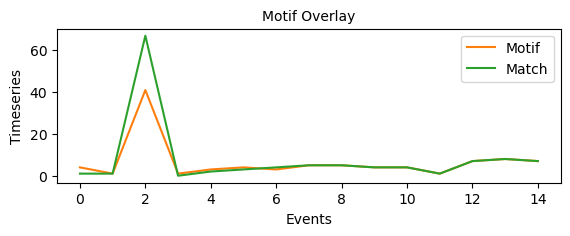

In [14]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6.5, 4))
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

#Plot Event data
axs[0].scatter(rows, ids, alpha=0.8)
axs[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs[1].plot(event_series)
axs[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
# Plot Matrix profiles
axs[2].set_xlabel('Events', fontsize ='10')
axs[2].set_ylabel('Matrix Profile', fontsize='10')
axs[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
axs[0].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[0].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
plt.show()

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
ax.plot(event_series[motif_idx_tm:motif_idx_tm+window_size], color='C1', label="Motif")
ax.plot(event_series[nearest_neighbor_idx_tm:nearest_neighbor_idx_tm+window_size], color='C2', label="Match")
plt.legend(loc="best",fontsize=10)
plt.show()

In [4]:
# Print the desired rows
display(df.iloc[motif_idx_tm:min(motif_idx_tm + window_size, len(df))])
display(df.iloc[nearest_neighbor_idx_tm:min(nearest_neighbor_idx_tm + window_size, len(df))])

NameError: name 'motif_idx_tm' is not defined

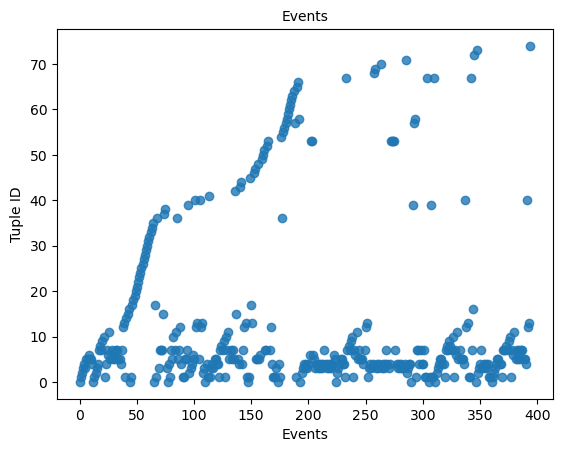

In [25]:
# Events only plot
fig, ax = plt.subplots()
plt.title('Events', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.scatter(rows, ids, alpha=0.8)
plt.show()

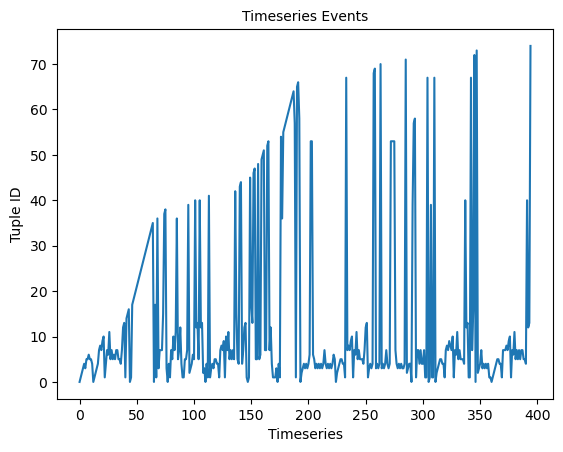

In [26]:
# Matrix Profil only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(event_series)
# Plot motif and nearest neighbor window
plt.show()

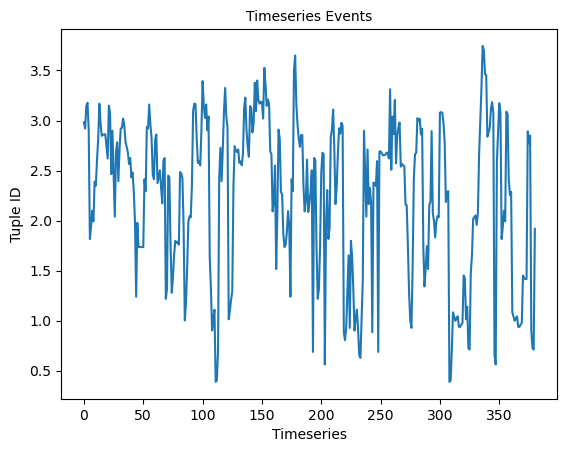

In [27]:
#Timeseries plot only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(tm_matrix[:, 0])
plt.show()

## Find Top-K Motifs

From https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-Top-K-Motifs

Now that you’ve computed the matrix profile, mp, for your time series and identified the best global motif, you may be interested in discovering other motifs within your data. However, you’ll immediately learn that doing something like top_10_motifs_idx = np.argsort(mp[:, 0])[10] doesn’t actually get you what you want and that’s because this only returns the index locations that are likely going to be close to the global motif! Instead, after identifying the best motif (i.e., the matrix profile location with the smallest value), you first need to exclude the local area (i.e., an exclusion zone) surrounding the motif pair by setting their matrix profile values to np.inf before searching for the next motif. Then, you’ll need to repeat the “exclude-and-search” process for each subsequent motif. Luckily, STUMPY offers two additional functions, namely, stumpy.motifs and stumpy.match, that help simplify this process. While it is beyond the scope of this basic tutorial, we encourage you to check them out!



In [17]:
# ToDo: When a motif is discovered: Find all equal motifs in the data and extract (CTRL+X) them from the frame into a new frame
#    this new frame contains all variants of a motif and could be input to smartRPAs routine variant discovery
# Repeat until no motifs are found anymore

# min_neighbours: With min_neighbours one can select how often a process motif has to appear at least to be relevant => map this to number of executions
# max_matches
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=10)
top_motifs

(array([[3.05382930e-07, 6.80577016e-01, 9.83837806e-01, 1.22977168e+00,
         1.65582225e+00, 3.67219101e+00, 3.68110780e+00, 3.90163264e+00,
         3.91721402e+00, 4.27987771e+00]]),
 array([[203, 347, 310, 233, 113, 105,  75, 304, 192, 263]], dtype=int64))

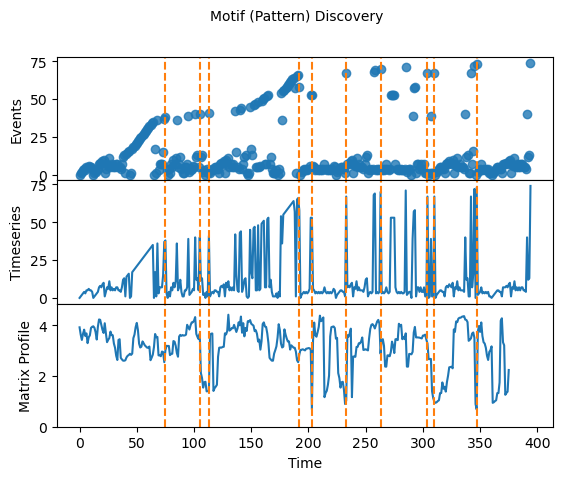

In [15]:
#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
# Plot Matrix profiles
axs2[2].set_xlabel('Time', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

plt.show()

In [34]:
# Creates a dataframe that contains all paths from the top_motifs result 
allMotifsDF = pd.DataFrame() 
for i, element in enumerate(top_motifs[1][0]):
    motif_start = top_motifs[1][0][i]
    motifFrame = df.loc[motif_start:motif_start+window_size]
    frames = [allMotifsDF,motifFrame]
    allMotifsDF = pd.concat(frames)
    print(motifFrame)

allMotifsDF

     case:concept:name           case:creator lifecycle:transition  \
111    309093506288000  SmartRPA by marco2012             complete   
112    309093506288000  SmartRPA by marco2012             complete   
113    309093506288000  SmartRPA by marco2012             complete   
114    309093506288000  SmartRPA by marco2012             complete   
115    309093506288000  SmartRPA by marco2012             complete   
116    309093506288000  SmartRPA by marco2012             complete   
117    309093506288000  SmartRPA by marco2012             complete   
118    309093506288000  SmartRPA by marco2012             complete   
119    309093506288000  SmartRPA by marco2012             complete   
120    309093506288000  SmartRPA by marco2012             complete   
121    309093506288000  SmartRPA by marco2012             complete   
122    309093506288000  SmartRPA by marco2012             complete   
123    309093506288000  SmartRPA by marco2012             complete   
124    3090935062880

,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_relevance,event_src_path,...,tag_href,tag_innerText,tag_option,tag_attributes,xpath,xpath_full,screenshot,concept:name:id,application:id,category:id
111,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:12.156,tomho,Browser,Edge,link,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,27,1
112,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:12.911,tomho,Browser,Edge,selectTab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,27,1
113,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:14.981,tomho,Browser,Edge,closeTab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,27,1
114,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:14.999,tomho,Browser,Edge,selectTab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,27,1
115,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:16.072,tomho,Browser,Edge,clickLink,NaN,NaN,...,https://www.frankfurter-sparkasse.de/de/home/l...,Demo Online-Banking chipTAN - Frankfurter Spar...,NaN,"{'data-test-id': 'result-link', 'href': 'https...","id(""main"")/div[1]/section[1]/div[2]/div[5]/art...",/HTML[1]/BODY[1]/DIV[1]/DIV[1]/DIV[1]/MAIN[1]/...,NaN,24,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:14.999,tomho,Browser,Edge,selectTab,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,27,1
115,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:16.072,tomho,Browser,Edge,clickLink,NaN,NaN,...,https://www.frankfurter-sparkasse.de/de/home/l...,Demo Online-Banking chipTAN - Frankfurter Spar...,NaN,"{'data-test-id': 'result-link', 'href': 'https...","id(""main"")/div[1]/section[1]/div[2]/div[5]/art...",/HTML[1]/BODY[1]/DIV[1]/DIV[1]/DIV[1]/MAIN[1]/...,NaN,24,27,1
116,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:16.456,tomho,Browser,Edge,link,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,27,1
117,309093506288000,SmartRPA by marco2012,complete,2024-03-09T09:46:19.444,tomho,Browser,Edge,clickLink,NaN,NaN,...,https://www.frankfurter-sparkasse.de/de/home/l...,Ablehnen,NaN,"{'href': '#', 'data-form': '.eprivacy_optin_de...",/html[1]/body[1]/div[1]/div[10]/div[1]/div[1]/...,/HTML[1]/BODY[1]/DIV[1]/DIV[10]/DIV[1]/DIV[1]/...,NaN,24,27,1


### Matching motives from most appearing motifs

Find all matches of a query `Q` in a time series `T`

The indices of subsequences whose distances to `Q` are less than or equal to `max_distance`, sorted by distance (lowest to highest). Around each occurrence an exclusion zone is applied before searching for the next.

In [219]:
firstMotif = top_motifs[1][0][0]
foundMotif = event_series[firstMotif:firstMotif+window_size]
matchingPatterns = stumpy.match(Q=foundMotif,T=event_series,max_distance=5.0)
print(firstMotif)
print(matchingPatterns)

2790
[[1.3328003749250113e-07 2790]
 [1.562846970811712e-07 5786]
 [1.1780568923589976 6978]
 ...
 [4.993997041443446 4581]
 [4.994376610193946 2977]
 [4.995867118858628 909]]


## Identify process start and end

1. It is necessary to identify if it is the same process that was identified.
2. It is necessary to identify the start and end of the process:
    Where is the initial action? What is an initial action? What is the last action?